<a href="https://colab.research.google.com/github/MLDreamer/AIMathematicallyexplained/blob/main/LLM_Reasoning_Statistics_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LLM REASONING STATISTICS PLAYGROUND

1. Variance Reduction with Multiple Samples


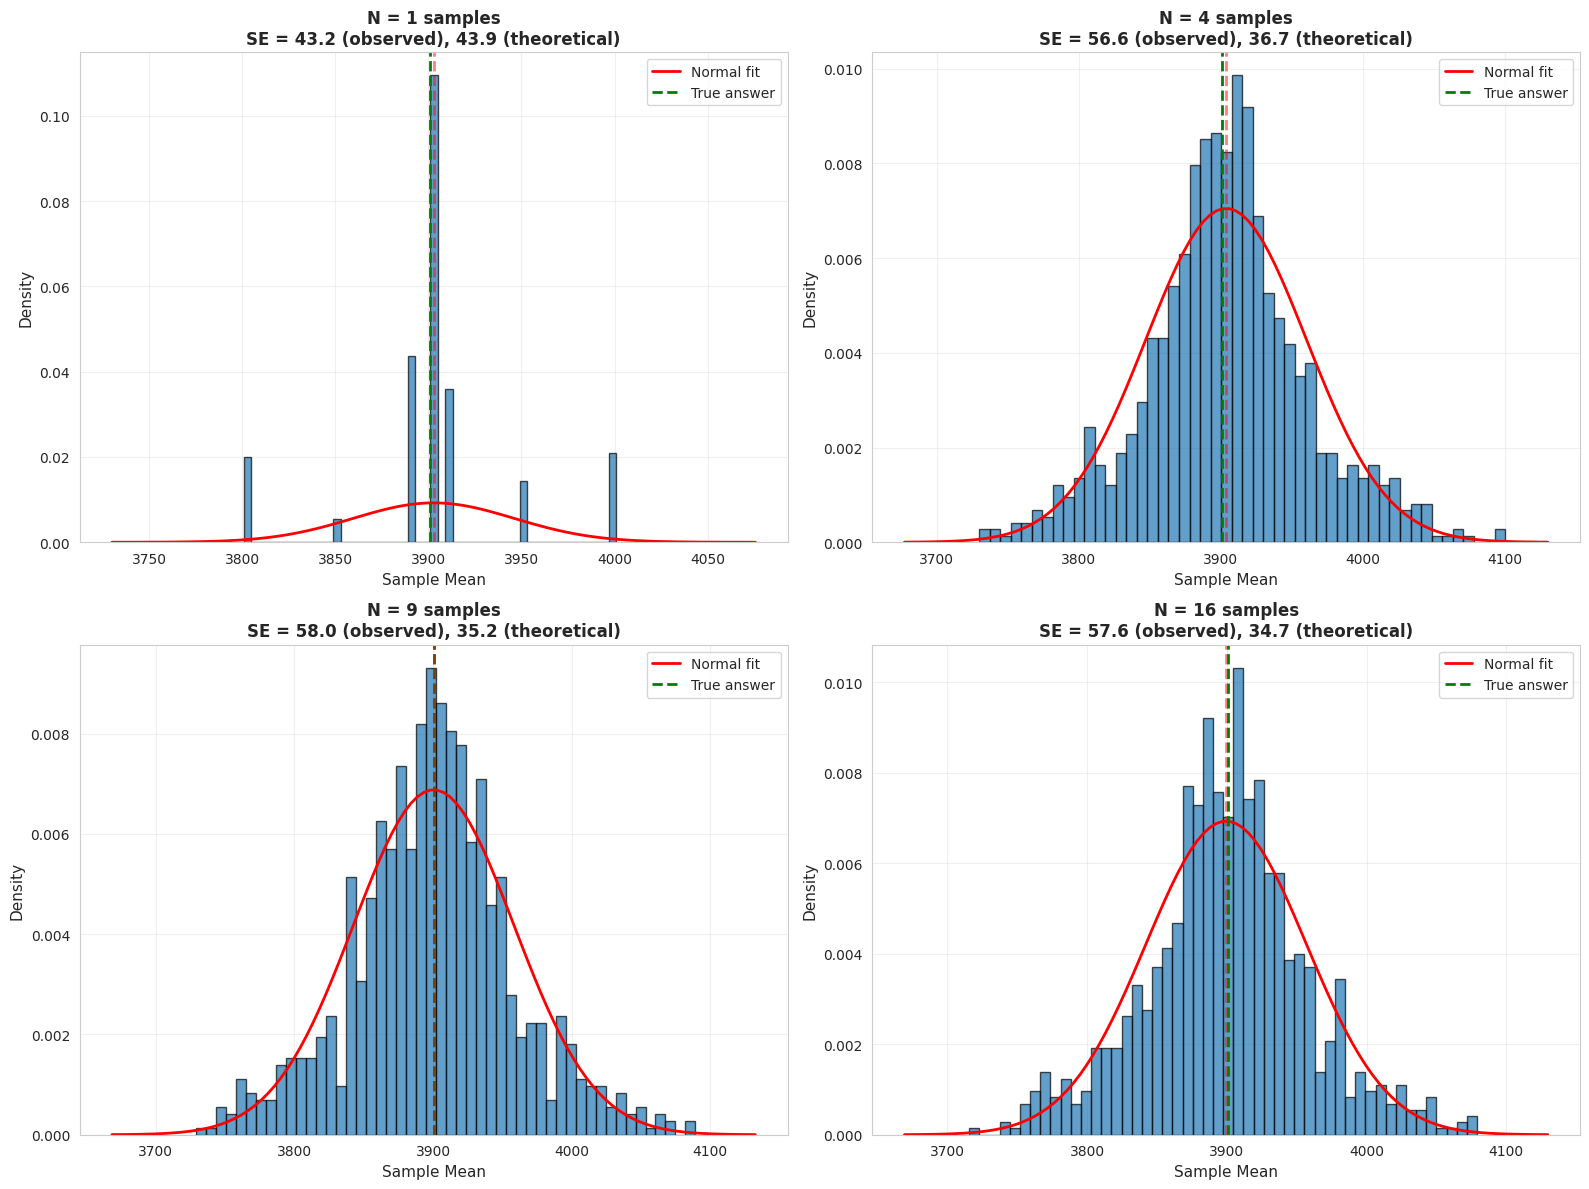


2. Error Scaling with Correlation


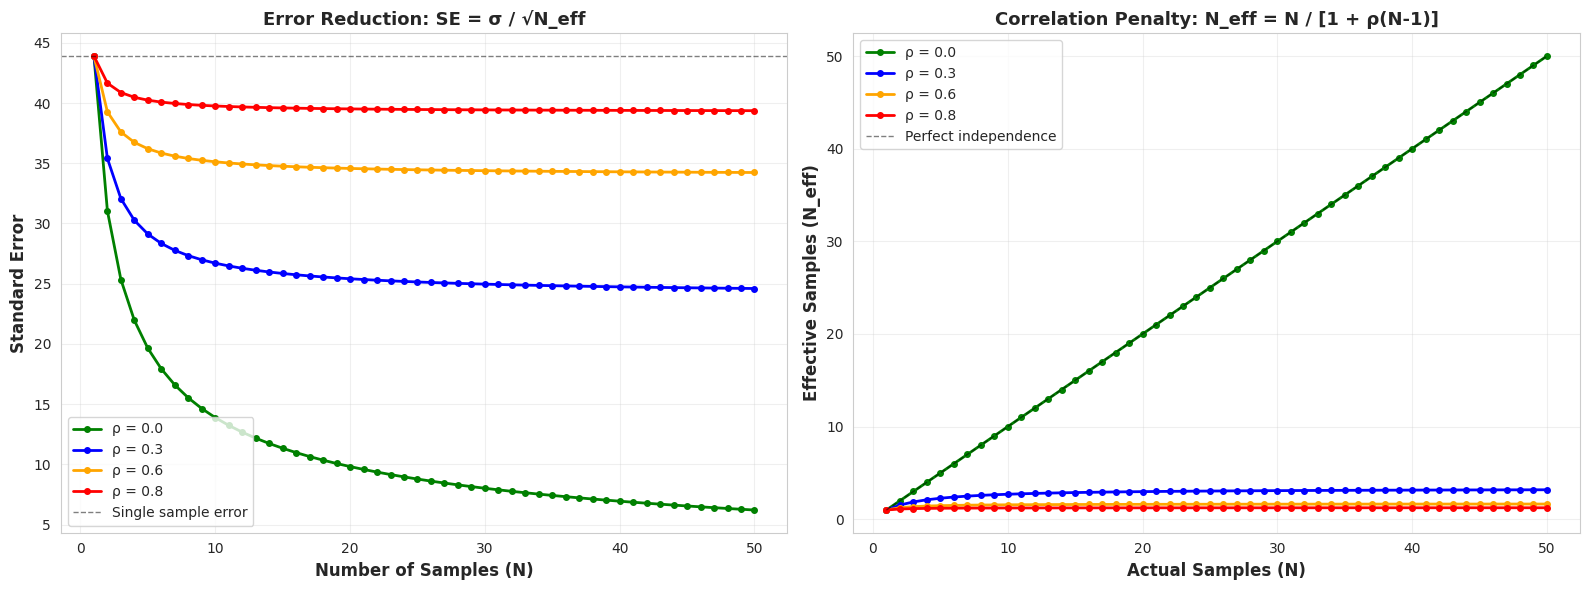


3. Dart Thrower Analogy


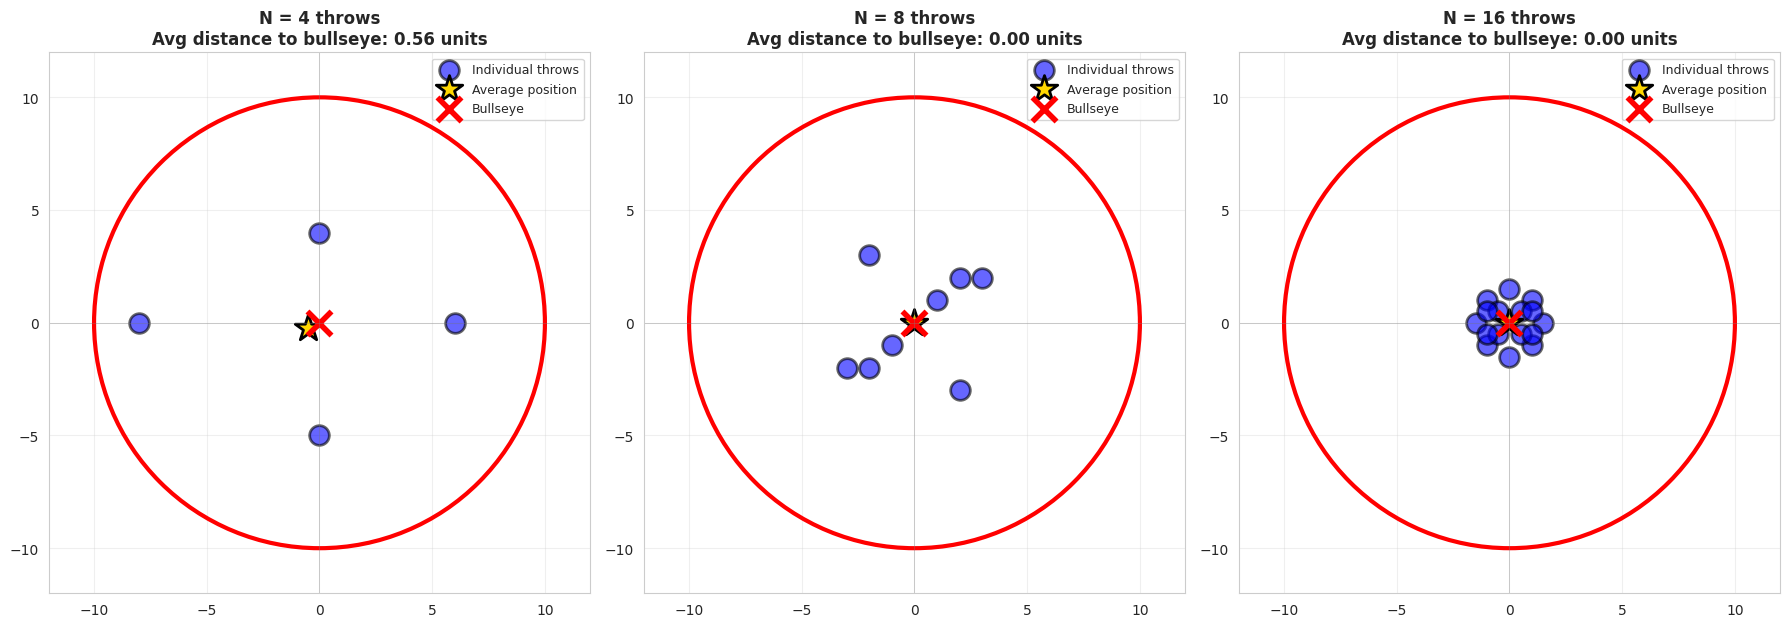


4. Chain-of-Thought vs Direct Answering


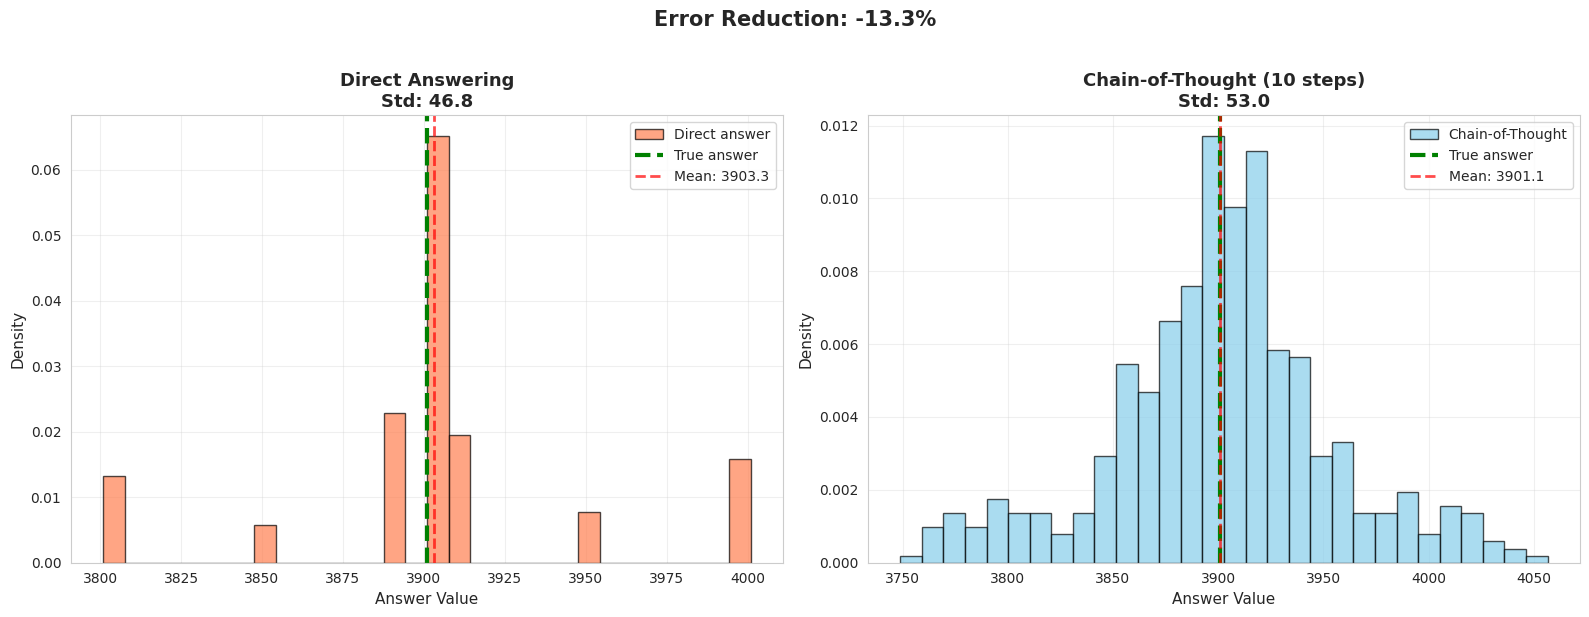


5. Confidence Intervals by Sample Size


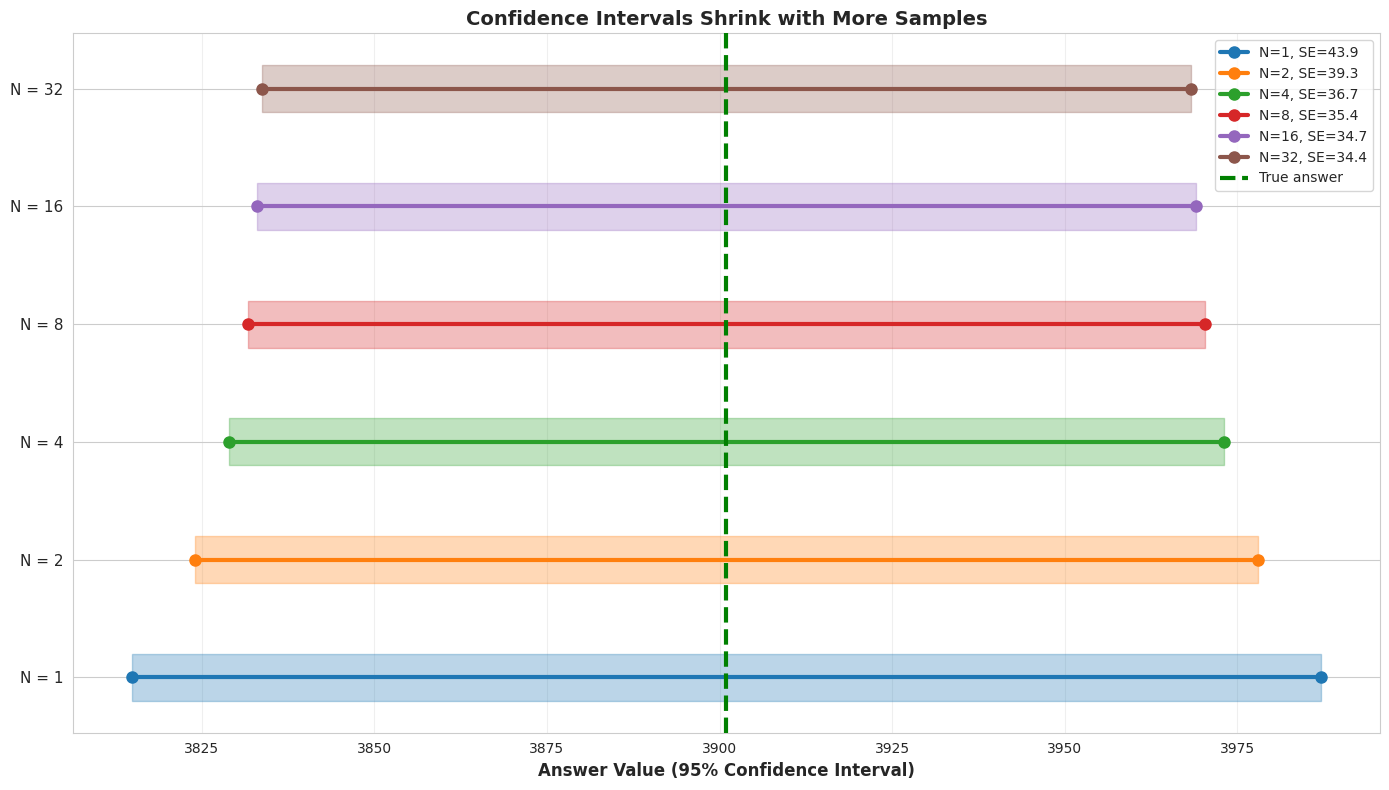


KEY INSIGHTS:
Base uncertainty (σ): 43.9
With N=4 samples, ρ=0.6: SE = 36.7
Error reduction: 16.3%
Effective sample size: 1.43


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

class LLMSamplingSimulator:
    def __init__(self, true_answer=3901, base_std=43.9, seed=42):
        self.true_answer = true_answer
        self.base_std = base_std
        np.random.seed(seed)

        self.answer_distribution = {
            3901: 0.42,
            3891: 0.18,
            3911: 0.15,
            4001: 0.09,
            3801: 0.08,
            3951: 0.05,
            3851: 0.03
        }

    def generate_single_sample(self):
        answers = list(self.answer_distribution.keys())
        probs = list(self.answer_distribution.values())
        return np.random.choice(answers, p=probs)

    def generate_correlated_samples(self, n_samples, correlation=0.6):
        base_sample = self.generate_single_sample()
        noise = np.random.normal(0, self.base_std * np.sqrt(1 - correlation), n_samples)
        correlated_noise = np.random.normal(0, self.base_std * np.sqrt(correlation), 1)

        samples = base_sample + noise + correlated_noise
        return np.clip(samples, 3700, 4100).astype(int)

    def compute_effective_sample_size(self, n_samples, correlation):
        return n_samples / (1 + correlation * (n_samples - 1))

    def compute_standard_error(self, n_samples, correlation):
        n_eff = self.compute_effective_sample_size(n_samples, correlation)
        return self.base_std / np.sqrt(n_eff)

simulator = LLMSamplingSimulator()

def visualize_single_vs_multiple():
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    sample_sizes = [1, 4, 9, 16]

    for idx, (ax, n) in enumerate(zip(axes.flat, sample_sizes)):
        sample_means = []

        for _ in range(1000):
            if n == 1:
                samples = [simulator.generate_single_sample()]
            else:
                samples = simulator.generate_correlated_samples(n, correlation=0.6)
            sample_means.append(np.mean(samples))

        ax.hist(sample_means, bins=50, density=True, alpha=0.7, edgecolor='black')

        mean = np.mean(sample_means)
        std = np.std(sample_means)

        x = np.linspace(mean - 4*std, mean + 4*std, 100)
        ax.plot(x, stats.norm.pdf(x, mean, std), 'r-', linewidth=2, label='Normal fit')

        ax.axvline(simulator.true_answer, color='green', linestyle='--', linewidth=2, label='True answer')
        ax.axvline(mean, color='red', linestyle='--', linewidth=2, alpha=0.5)

        theoretical_se = simulator.compute_standard_error(n, 0.6)

        ax.set_title(f'N = {n} samples\nSE = {std:.1f} (observed), {theoretical_se:.1f} (theoretical)',
                     fontsize=12, fontweight='bold')
        ax.set_xlabel('Sample Mean', fontsize=11)
        ax.set_ylabel('Density', fontsize=11)
        ax.legend()
        ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('variance_reduction.png', dpi=150, bbox_inches='tight')
    plt.show()

def visualize_error_scaling():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    n_range = np.arange(1, 51)

    correlations = [0.0, 0.3, 0.6, 0.8]
    colors = ['green', 'blue', 'orange', 'red']

    for corr, color in zip(correlations, colors):
        errors = [simulator.compute_standard_error(n, corr) for n in n_range]
        ax1.plot(n_range, errors, marker='o', markersize=4, linewidth=2,
                color=color, label=f'ρ = {corr}')

    ax1.axhline(simulator.base_std, color='black', linestyle='--',
               linewidth=1, alpha=0.5, label='Single sample error')
    ax1.set_xlabel('Number of Samples (N)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Standard Error', fontsize=12, fontweight='bold')
    ax1.set_title('Error Reduction: SE = σ / √N_eff', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(alpha=0.3)

    for corr, color in zip(correlations, colors):
        n_eff = [simulator.compute_effective_sample_size(n, corr) for n in n_range]
        ax2.plot(n_range, n_eff, marker='o', markersize=4, linewidth=2,
                color=color, label=f'ρ = {corr}')

    ax2.plot(n_range, n_range, 'k--', linewidth=1, alpha=0.5, label='Perfect independence')
    ax2.set_xlabel('Actual Samples (N)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Effective Samples (N_eff)', fontsize=12, fontweight='bold')
    ax2.set_title('Correlation Penalty: N_eff = N / [1 + ρ(N-1)]', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('error_scaling.png', dpi=150, bbox_inches='tight')
    plt.show()

def visualize_dart_thrower_analogy():
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    bullseye = np.array([0, 0])

    throws_sets = [
        [(6, 0), (-8, 0), (0, 4), (0, -5)],
        [(3, 2), (-2, 3), (2, -3), (-3, -2), (1, 1), (-1, -1), (2, 2), (-2, -2)],
        [(1, 1), (-1, 1), (1, -1), (-1, -1), (0.5, 0.5), (-0.5, 0.5),
         (0.5, -0.5), (-0.5, -0.5), (1.5, 0), (-1.5, 0), (0, 1.5), (0, -1.5),
         (1, 0.5), (-1, 0.5), (1, -0.5), (-1, -0.5)]
    ]

    titles = ['N = 4 throws', 'N = 8 throws', 'N = 16 throws']

    for ax, throws, title in zip(axes, throws_sets, titles):
        circle = plt.Circle((0, 0), 10, fill=False, edgecolor='red', linewidth=3)
        ax.add_patch(circle)

        throws_array = np.array(throws)
        ax.scatter(throws_array[:, 0], throws_array[:, 1], s=200, c='blue',
                  alpha=0.6, edgecolors='black', linewidth=2, label='Individual throws')

        mean_position = np.mean(throws_array, axis=0)
        ax.scatter(mean_position[0], mean_position[1], s=400, c='gold',
                  marker='*', edgecolors='black', linewidth=2, label='Average position')

        ax.scatter(0, 0, s=300, c='red', marker='x', linewidth=4, label='Bullseye')

        distance_to_bullseye = np.linalg.norm(mean_position - bullseye)
        ax.set_title(f'{title}\nAvg distance to bullseye: {distance_to_bullseye:.2f} units',
                    fontsize=12, fontweight='bold')
        ax.set_xlim(-12, 12)
        ax.set_ylim(-12, 12)
        ax.set_aspect('equal')
        ax.legend(loc='upper right', fontsize=9)
        ax.grid(alpha=0.3)
        ax.axhline(0, color='gray', linewidth=0.5, alpha=0.5)
        ax.axvline(0, color='gray', linewidth=0.5, alpha=0.5)

    plt.tight_layout()
    plt.savefig('dart_thrower_analogy.png', dpi=150, bbox_inches='tight')
    plt.show()

def simulate_cot_vs_direct():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    n_trials = 500

    direct_answers = [simulator.generate_single_sample() for _ in range(n_trials)]

    cot_answers = []
    for _ in range(n_trials):
        intermediate_steps = simulator.generate_correlated_samples(10, correlation=0.4)
        cot_answers.append(np.mean(intermediate_steps))

    ax1.hist(direct_answers, bins=30, density=True, alpha=0.7, edgecolor='black',
            color='coral', label='Direct answer')
    ax1.axvline(simulator.true_answer, color='green', linestyle='--', linewidth=3,
               label='True answer')
    ax1.axvline(np.mean(direct_answers), color='red', linestyle='--', linewidth=2,
               alpha=0.7, label=f'Mean: {np.mean(direct_answers):.1f}')
    ax1.set_title(f'Direct Answering\nStd: {np.std(direct_answers):.1f}',
                 fontsize=13, fontweight='bold')
    ax1.set_xlabel('Answer Value', fontsize=11)
    ax1.set_ylabel('Density', fontsize=11)
    ax1.legend()
    ax1.grid(alpha=0.3)

    ax2.hist(cot_answers, bins=30, density=True, alpha=0.7, edgecolor='black',
            color='skyblue', label='Chain-of-Thought')
    ax2.axvline(simulator.true_answer, color='green', linestyle='--', linewidth=3,
               label='True answer')
    ax2.axvline(np.mean(cot_answers), color='red', linestyle='--', linewidth=2,
               alpha=0.7, label=f'Mean: {np.mean(cot_answers):.1f}')
    ax2.set_title(f'Chain-of-Thought (10 steps)\nStd: {np.std(cot_answers):.1f}',
                 fontsize=13, fontweight='bold')
    ax2.set_xlabel('Answer Value', fontsize=11)
    ax2.set_ylabel('Density', fontsize=11)
    ax2.legend()
    ax2.grid(alpha=0.3)

    improvement = (1 - np.std(cot_answers) / np.std(direct_answers)) * 100
    fig.suptitle(f'Error Reduction: {improvement:.1f}%', fontsize=15, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.savefig('cot_vs_direct.png', dpi=150, bbox_inches='tight')
    plt.show()

def confidence_intervals_by_n():
    fig, ax = plt.subplots(figsize=(14, 8))

    sample_sizes = [1, 2, 4, 8, 16, 32]
    correlation = 0.6

    y_positions = np.arange(len(sample_sizes))

    for i, n in enumerate(sample_sizes):
        se = simulator.compute_standard_error(n, correlation)
        ci_lower = simulator.true_answer - 1.96 * se
        ci_upper = simulator.true_answer + 1.96 * se

        ax.plot([ci_lower, ci_upper], [i, i], 'o-', linewidth=3, markersize=8,
               color=f'C{i}', label=f'N={n}, SE={se:.1f}')

        ax.fill_betweenx([i-0.2, i+0.2], ci_lower, ci_upper, alpha=0.3, color=f'C{i}')

    ax.axvline(simulator.true_answer, color='green', linestyle='--', linewidth=3,
              label='True answer', zorder=10)

    ax.set_yticks(y_positions)
    ax.set_yticklabels([f'N = {n}' for n in sample_sizes], fontsize=11)
    ax.set_xlabel('Answer Value (95% Confidence Interval)', fontsize=12, fontweight='bold')
    ax.set_title('Confidence Intervals Shrink with More Samples', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(alpha=0.3, axis='x')

    plt.tight_layout()
    plt.savefig('confidence_intervals.png', dpi=150, bbox_inches='tight')
    plt.show()

print("=" * 80)
print("LLM REASONING STATISTICS PLAYGROUND")
print("=" * 80)
print("\n1. Variance Reduction with Multiple Samples")
visualize_single_vs_multiple()

print("\n2. Error Scaling with Correlation")
visualize_error_scaling()

print("\n3. Dart Thrower Analogy")
visualize_dart_thrower_analogy()

print("\n4. Chain-of-Thought vs Direct Answering")
simulate_cot_vs_direct()

print("\n5. Confidence Intervals by Sample Size")
confidence_intervals_by_n()

print("\n" + "=" * 80)
print("KEY INSIGHTS:")
print("=" * 80)
print(f"Base uncertainty (σ): {simulator.base_std:.1f}")
print(f"With N=4 samples, ρ=0.6: SE = {simulator.compute_standard_error(4, 0.6):.1f}")
print(f"Error reduction: {(1 - simulator.compute_standard_error(4, 0.6)/simulator.base_std)*100:.1f}%")
print(f"Effective sample size: {simulator.compute_effective_sample_size(4, 0.6):.2f}")
print("=" * 80)